In [2]:
%pip install -r requirements.txt

  Using cached setuptools-75.3.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.1.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pillow-11.0.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached keras-3.6.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt

In [4]:
%pip install --upgrade setuptools

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random

from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.metrics import accuracy_score
from keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization, Input, Dense, GlobalAveragePooling2D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
train_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration\Train'
test_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration\Test'

train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

In [3]:
# Count images by class
def count_images_by_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images_by_class(train_dir)
test_counts = count_images_by_class(test_dir)

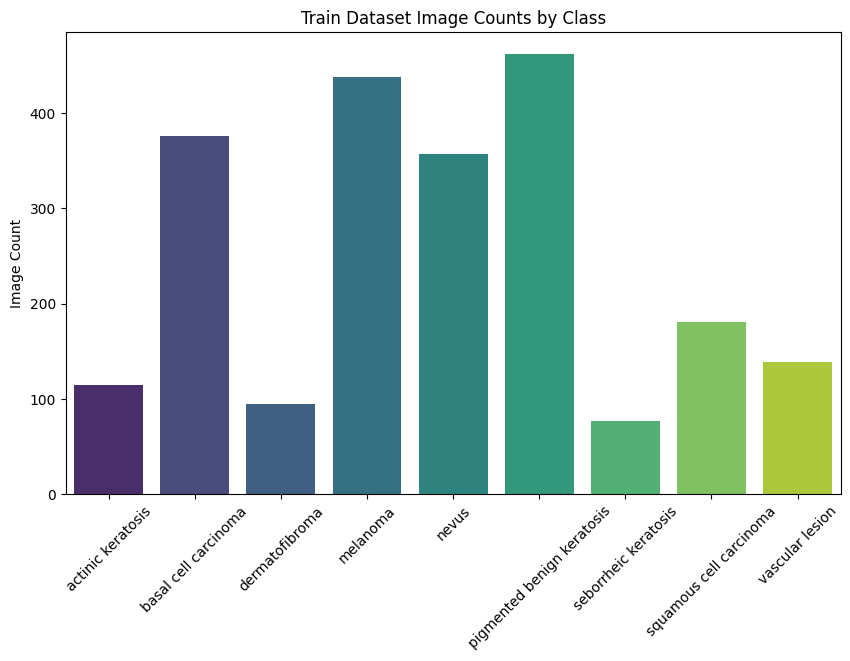

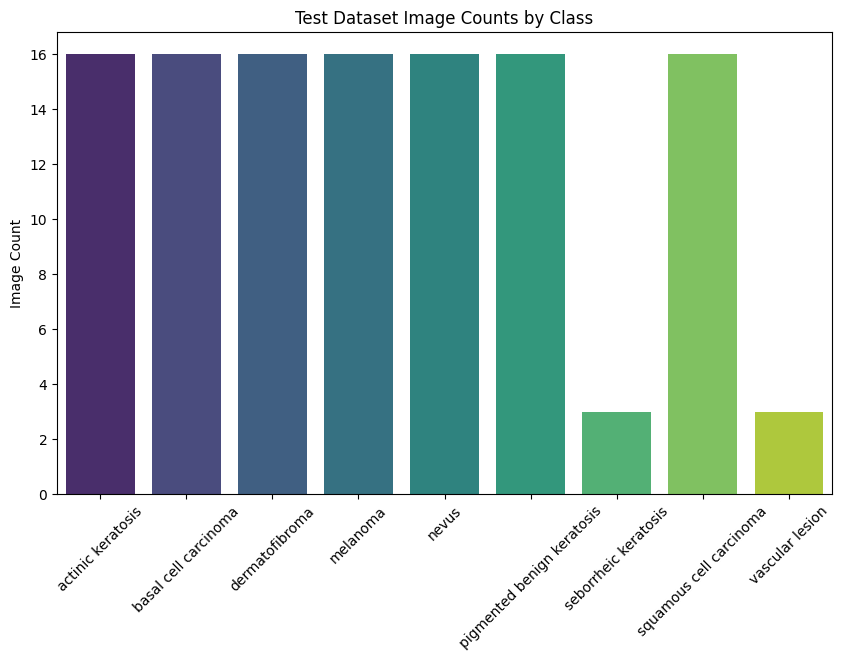

In [4]:
# Plot class counts
def plot_class_counts(class_counts, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title(title)
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)
    plt.show()

plot_class_counts(train_counts, "Train Dataset Image Counts by Class")
plot_class_counts(test_counts, "Test Dataset Image Counts by Class")


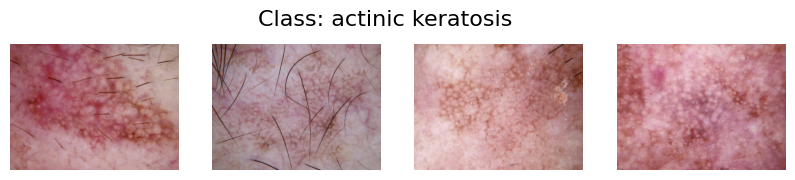

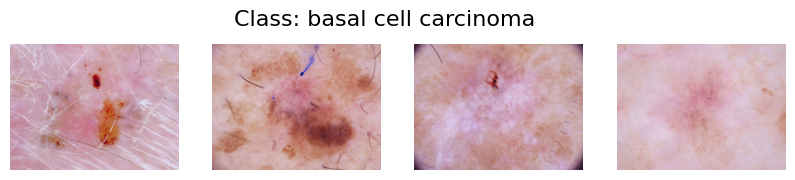

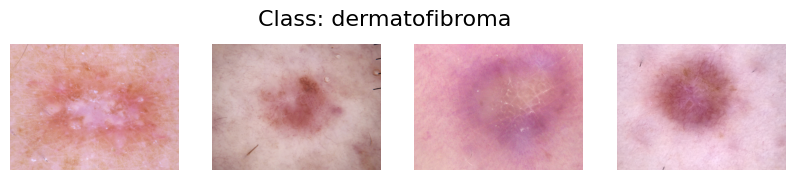

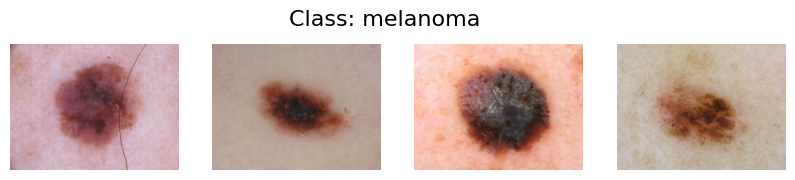

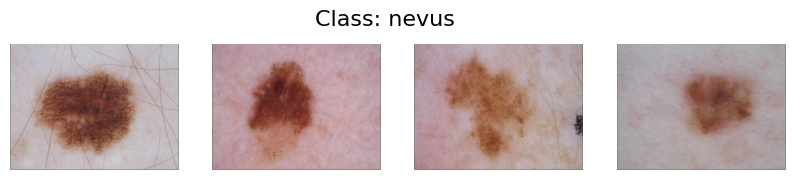

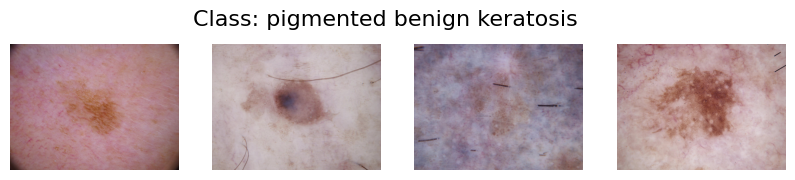

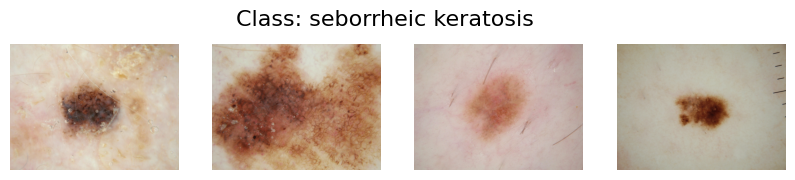

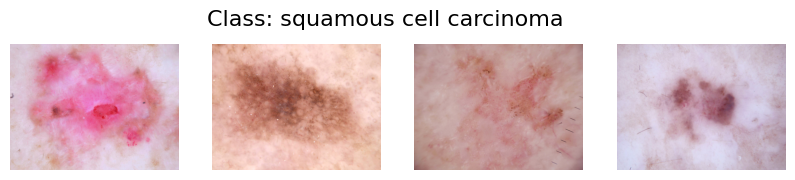

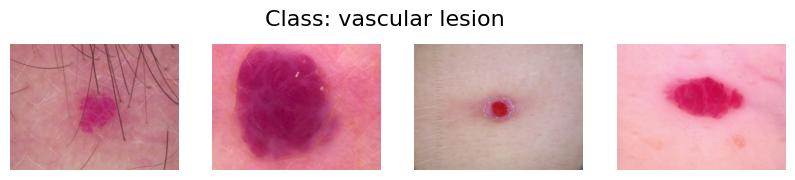

In [5]:
# Display images per class
def display_images_per_class(directory, n_images=4):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)[:n_images]
            plt.figure(figsize=(10, 2))
            plt.suptitle(f"Class: {class_name}", fontsize=16)
            for i, img_file in enumerate(image_files):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path)
                plt.subplot(1, n_images, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()

display_images_per_class(train_dir)


In [6]:
# Augmentation strategy
TARGET_COUNT = 2000
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

X_train = []
Y_train = []


In [7]:
# Load and augment images
def load_and_augment_images(directory, class_name, current_count, target_count):
    image_files = os.listdir(directory)
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        img = Image.open(img_path).resize((150, 150))
        img_array = np.array(img).astype('float32') / 255.0
        X_train.append(img_array)
        Y_train.append(class_name)
    while current_count < target_count:
        img_file = random.choice(image_files)
        img_path = os.path.join(directory, img_file)
        img = Image.open(img_path).resize((150, 150))
        img_array = np.array(img).astype('float32') / 255.0
        img_array = np.expand_dims(img_array, 0)
        augmented_img = next(datagen.flow(img_array, batch_size=1))[0].astype('float32')
        X_train.append(augmented_img)
        Y_train.append(class_name)
        current_count += 1

for class_name, count in train_counts.items():
    class_dir = os.path.join(train_dir, class_name)
    load_and_augment_images(class_dir, class_name, count, TARGET_COUNT)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [8]:
# Transform labels
def transform_Y(y):
    labels_dict = {
        'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4,
        'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8
    }
    return labels_dict.get(y, -1)

x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
y_train = np.array([transform_Y(y) for y in y_train])
y_valid = np.array([transform_Y(y) for y in y_valid])

In [9]:
# Load test data
X_test = []
y_test = []

def load_test_images(directory, class_name):
    image_files = os.listdir(directory)
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        img = Image.open(img_path).resize((150, 150))
        img_array = np.array(img).astype('float32') / 255.0
        X_test.append(img_array)
        encoded_label = transform_Y(class_name)
        y_test.append(encoded_label)

for class_name in test_classes:
    class_dir = os.path.join(test_dir, class_name)
    load_test_images(class_dir, class_name)

x_test = np.array(X_test)
y_test = np.array(y_test)
y_train_one_hot = to_categorical(y_train, num_classes=9)
y_valid_one_hot = to_categorical(y_valid, num_classes=9)
y_test_one_hot = to_categorical(y_test, num_classes=9)


In [10]:
# Model creation function
def create_transfer_model(base_model):
    base_model.trainable = False
    input_layer = Input(shape=(150, 150, 3))
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    output_layer = Dense(9, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [13]:
from tensorflow.keras.models import Model

# ResNet50 model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet_model = create_transfer_model(resnet50_base)
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 599s 5s/step - accuracy: 0.3188 - loss: 1.8663 - val_accuracy: 0.1067 - val_loss: 6.1723
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - accuracy: 0.4520 - loss: 1.4491 - val_accuracy: 0.1067 - val_loss: 5.4113
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 636s 6s/step - accuracy: 0.4996 - loss: 1.3441 - val_accuracy: 0.1067 - val_loss: 9.1366
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 978s 9s/step - accuracy: 0.5377 - loss: 1.2525 - val_accuracy: 0.1242 - val_loss: 9.0917
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 991s 9s/step - accuracy: 0.5630 - loss: 1.2003 - val_accuracy: 0.1208 - val_loss: 15.2281
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 732s 6s/step - accuracy: 0.5790 - loss: 1.1425 - val_accuracy: 0.1358 - val_loss: 8.9171


In [14]:
# VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_model = create_transfer_model(vgg16_base)
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=4)])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1172s 10s/step - accuracy: 0.4339 - loss: 1.5805 - val_accuracy: 0.2964 - val_loss: 1.9356
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1343s 12s/step - accuracy: 0.6303 - loss: 1.0395 - val_accuracy: 0.4122 - val_loss: 1.8029
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1400s 12s/step - accuracy: 0.6926 - loss: 0.8522 - val_accuracy: 0.4933 - val_loss: 1.4316
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1152s 10s/step - accuracy: 0.7387 - loss: 0.7408 - val_accuracy: 0.5336 - val_loss: 1.2751
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1150s 10s/step - accuracy: 0.7732 - loss: 0.6612 - val_accuracy: 0.5617 - val_loss: 1.1646
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1176s 10s/step - accuracy: 0.7836 - loss: 0.6149 - val_accuracy: 0.4756 - val_loss: 1.6075
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1181s 10s/step - accuracy: 0.8154 - loss: 0.5412 - val_accuracy: 0.4822 - val_loss: 1.6731
Epoch 8/15
113/113 ━━━━━━━━━━━━━

In [15]:
# InceptionV3 model
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
inception_model = create_transfer_model(inceptionv3_base)
inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
inception_model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 474s 4s/step - accuracy: 0.4295 - loss: 1.6258 - val_accuracy: 0.5450 - val_loss: 1.3357
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 689s 6s/step - accuracy: 0.6892 - loss: 0.8837 - val_accuracy: 0.5603 - val_loss: 1.1555
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 690s 6s/step - accuracy: 0.7855 - loss: 0.6274 - val_accuracy: 0.6317 - val_loss: 1.0631
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - accuracy: 0.8368 - loss: 0.4784 - val_accuracy: 0.6094 - val_loss: 1.0990
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.8701 - loss: 0.3865 - val_accuracy: 0.6514 - val_loss: 1.0979
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.9060 - loss: 0.2812 - val_accuracy: 0.6461 - val_loss: 1.1455
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9234 - loss: 0.2313 - val_accuracy: 0.6672 - val_loss: 1.1351


In [18]:
# DenseNet201 model
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
densenet_model = create_transfer_model(densenet_base)
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
densenet_model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 890s 8s/step - accuracy: 0.5294 - loss: 1.3214 - val_accuracy: 0.6889 - val_loss: 0.8834
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 672s 6s/step - accuracy: 0.8335 - loss: 0.4828 - val_accuracy: 0.7556 - val_loss: 0.6402
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 664s 6s/step - accuracy: 0.8956 - loss: 0.3170 - val_accuracy: 0.8044 - val_loss: 0.5537
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 664s 6s/step - accuracy: 0.9231 - loss: 0.2389 - val_accuracy: 0.8181 - val_loss: 0.5237
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 679s 6s/step - accuracy: 0.9463 - loss: 0.1661 - val_accuracy: 0.8419 - val_loss: 0.4482
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.9549 - loss: 0.1385 - val_accuracy: 0.8356 - val_loss: 0.4797
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 648s 6s/step - accuracy: 0.9556 - loss: 0.1294 - val_accuracy: 0.8386 - val_loss: 0.5078
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 782s 7

In [20]:
def print_model_accuracies(history, model_name):
    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"{model_name} - Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

resnet_history = resnet_model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
vgg_history = vgg_model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
inception_history = inception_model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
densenet_history = densenet_model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_valid, y_valid), callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

print_model_accuracies(resnet_history, "ResNet50")
print_model_accuracies(vgg_history, "VGG16")
print_model_accuracies(inception_history, "InceptionV3")
print_model_accuracies(densenet_history, "DenseNet201")

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.6012 - loss: 1.0888 - val_accuracy: 0.1856 - val_loss: 14.7624
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6115 - loss: 1.0601 - val_accuracy: 0.1164 - val_loss: 47.9908
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.6292 - loss: 1.0116 - val_accuracy: 0.1169 - val_loss: 29.9146
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 452s 4s/step - accuracy: 0.6367 - loss: 0.9970 - val_accuracy: 0.1242 - val_loss: 26.3554
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 570s 5s/step - accuracy: 0.6484 - loss: 0.9611 - val_accuracy: 0.1158 - val_loss: 16.9414
Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1244s 11s/step - accuracy: 0.9031 - loss: 0.2887 - val_accuracy: 0.7269 - val_loss: 0.8175
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1169s 10s/step - accuracy: 0.9046 - loss: 0.2826 - val_accuracy: 0.6172 - val_loss: 1.4253
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1147s 10s/step - accuracy: 0.9187 - loss: 0.2442